In [ ]:
from google.colab import drive
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as tfk 
import tensorflow.keras.layers as tfkl 
plt.rc('font', size=16) 
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn import preprocessing 


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 89
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AN2DL_MY_FOLDER/My_Network_Trials/homework2

/content/drive/MyDrive/AN2DL_MY_FOLDER/My_Network_Trials/homework2


In [ ]:
#drive.mount('/gdrive')
#os.chdir(r'/gdrive/MyDrive/annHomework2/')
x_train = np.load(r'x_train.npy')
y_train = np.load(r'y_train.npy')

In [ ]:
x_train.shape, y_train.shape 

((2429, 36, 6), (2429,))

Is it already divided into windows? I would say yes. 

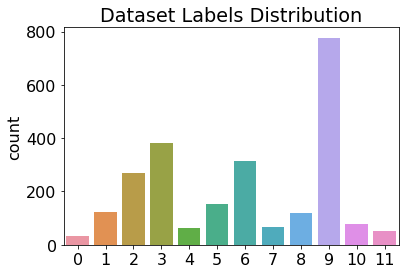

In [ ]:
# plot labels distribution 
sns.countplot( x = y_train) 
plt.title('Dataset Labels Distribution')
plt.show()

As we can see dataset is pretty unbalanced. But, looking at early subs, more prominent classes do not seem to be the best predicted. Why? 

In [ ]:
labels = np.unique(np.fromiter([i for i in y_train], np.int32) )
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=labels, y=y_train) 
y_train = tfk.utils.to_categorical(y_train) 

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=seed, stratify=y_train) 

In [ ]:
train_data = np.concatenate([x for x in x_train]) 
scaler = preprocessing.StandardScaler().fit(train_data)

x_train_trans = [] 
for el in x_train: 
  x_train_trans.append(scaler.transform(el))
del x_train 

x_test_trans = [] 
for el in x_test :
  x_test_trans.append(scaler.transform(el))

x_train = np.asarray(x_train_trans) 
x_test = np.asarray(x_test_trans)
x_train

array([[[-2.90050091e-02, -2.81173662e-02, -4.01353574e-02,
         -5.53498110e-02, -5.46742258e-02, -6.09063513e-02],
        [-2.38215685e-03, -3.19004134e-02, -3.89549832e-02,
         -4.78691087e-02, -5.46197556e-02, -2.53564193e-02],
        [-3.45932781e-02, -2.98535493e-02, -3.91401895e-02,
         -5.42391345e-02, -5.60820326e-02, -2.80452044e-02],
        ...,
        [-2.91089297e-02, -3.32062348e-02, -3.93279965e-02,
         -4.91459388e-02, -5.40693827e-02, -4.48911375e-02],
        [-2.48679790e-02, -3.19839185e-02, -4.00463717e-02,
         -5.09616227e-02, -5.37430767e-02, -3.56285344e-02],
        [-3.20287277e-02, -2.94060360e-02, -3.88550517e-02,
         -5.15765082e-02, -4.92820147e-02, -4.86436869e-02]],

       [[ 2.48908178e-02, -3.85289011e-02, -5.28285969e-02,
         -6.41620159e-02, -4.90246127e-02, -3.90544762e-02],
        [-1.59450337e-02, -3.67783347e-02, -4.10382651e-02,
         -5.92778300e-02, -6.14261312e-02, -1.99368861e-02],
        [-7.21036

In [ ]:
# check 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 
x_train[0][1]
y_train[0]

(1943, 36, 6) (1943, 12) (486, 36, 6) (486, 12)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

# **LSTM VANILLA**

In [ ]:
input_shape = (36,6)

#### 1D Convolutional Neural Network

![](https://drive.google.com/uc?export=view&id=10B7c-F58-eNr6CP7D_UZeVp0gTeYMrFQ
)

In [ ]:
def build_ffnn_classifier(input_shape, classes):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
     
    # bilstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer) 

    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer) # metto 128 filtri, con kernel_size (sarebbe dimensione filtro)=3
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)


    hidden_layer1 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden1', kernel_regularizer = tfk.regularizers.L2(l2 = 0.0001))(dropout) 

    hidden_layer2 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden2', kernel_regularizer = tfk.regularizers.L2(l2 = 0.0001))(hidden_layer1) 
    
    '''
    classifier = tfk.Sequential([ 
        tfkl.Input(shape=(128,)), 
        tfkl.experimental.RandomFourierFeatures(output_dim=1024, scale=8.0, kernel_initializer="gaussian"),
        tfkl.Dense(units=128,  activation='relu', 
                   kernel_initializer=tfk.initializers.HeUniform(seed),
                   name='dense_classifier1',
                  # kernel_regularizer = tfk.regularizers.L2( l2 = 0.001) # ,l1 = 0.01 )                   
                  ),
        tfkl.Dense(units=128,  activation='relu', 
                   kernel_initializer=tfk.initializers.HeUniform(seed),
                   name='dense_classifier2',
                  # kernel_regularizer = tfk.regularizers.L2(l2 = 0.001) #, l1= 0.01)                   
                  )
    ]) (gap)  
    '''
    
    output_layer = tfkl.Dense(classes, activation='softmax', 
                              #kernel_regularizer = tfk.regularizers.L2(l2 = 0.01),
                              kernel_initializer=tfk.initializers.GlorotUniform(seed))(hidden_layer2)
      
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

In [ ]:
model = build_ffnn_classifier(input_shape, 12)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 256)           4864      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 256)           196864    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 256)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 256)            196864

In [ ]:
history1 = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 1s 15ms/step - loss: 2.2292 - accuracy: 0.3423 - val_loss: 1.9276 - val_accuracy: 0.3663 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 9ms/step - loss: 1.9214 - accuracy: 0.3829 - val_loss: 1.8355 - val_accuracy: 0.3807 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 1.7967 - accuracy: 0.4138 - val_loss: 1.8747 - val_accuracy: 0.3868 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 1.7552 - accuracy: 0.4236 - val_loss: 1.7863 - val_accuracy: 0.4712 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 1.7079 - accuracy: 0.4287 - val_loss: 1.6410 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 8ms/step - loss: 1.5626 - accuracy: 0.4678 - val_loss: 1.5651 - val_accuracy: 0.4815 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 7ms/step - loss: 1.

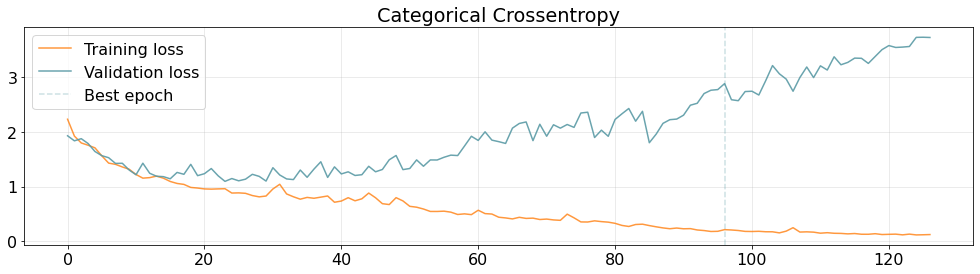

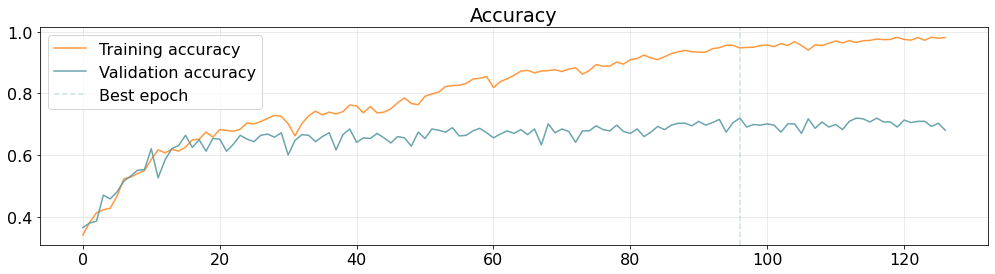

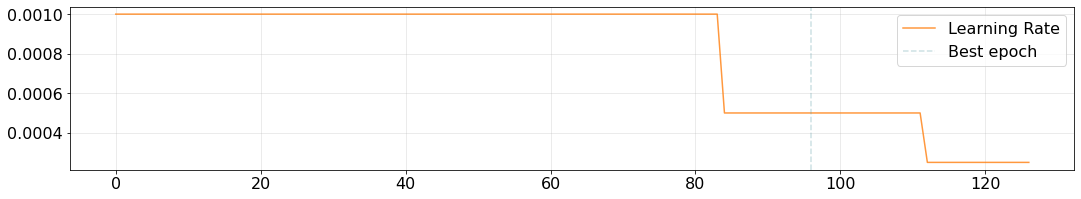

In [ ]:
best_epoch = np.argmax(history1['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history1['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history1['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history1['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
#model.save('1DCNN')

In [ ]:
predictions = model.predict(x_test)
predictions.shape

16/16 [==============================] - 0s 2ms/step


(486, 12)

16/16 [==============================] - 0s 2ms/step - loss: 0.0503 - accuracy: 0.0000e+00
{'loss': 0.05028146132826805, 'accuracy': 0.0}
16/16 [==============================] - 0s 2ms/step
Accuracy: 0.7202
Precision: 0.6511
Recall: 0.5657
F1: 0.5922
F1 (per class): [0.4        0.65384615 0.91262136 0.60645161 0.31578947 0.31372549
 0.88372093 0.11111111 0.86363636 0.7755102  0.88888889 0.38095238]


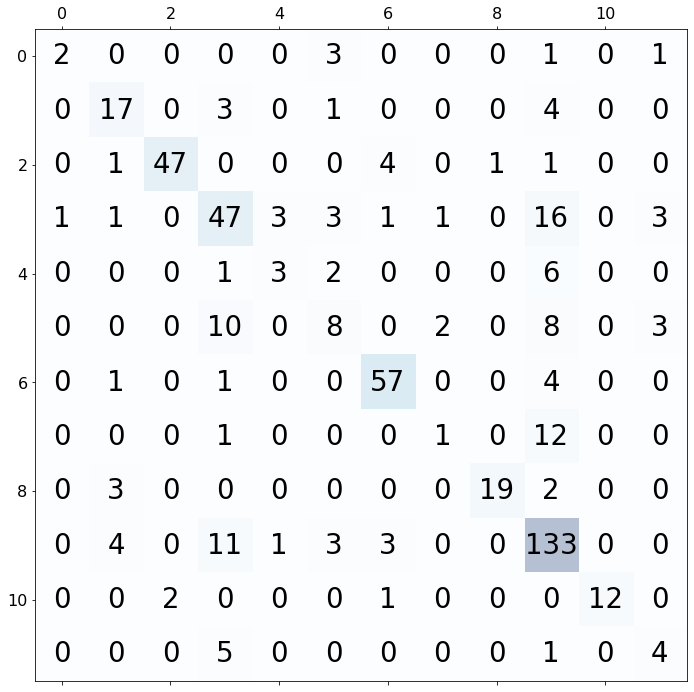

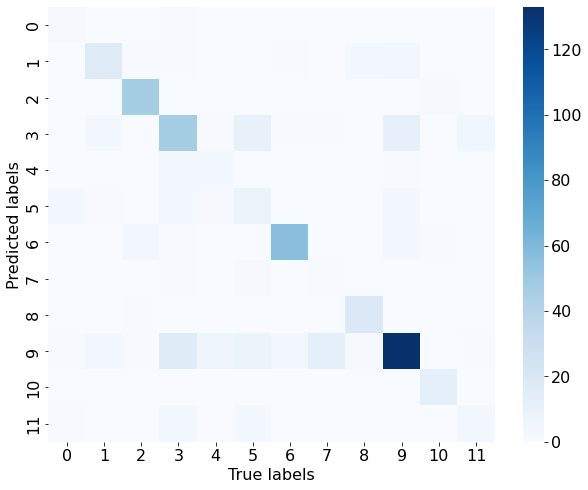

In [ ]:
metrics = model.evaluate(x_test, return_dict=True)
print(metrics)

labels = y_test 
predictions = model.predict(x_test) 
assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()